# SoS Syntax

## Terminology & Grammar

A SoS **script** defines one or more **workflows**, and each workflow consists of one or more **steps**. 

![workflow](../media/workflow.png)

SoS steps are defined by SoS **sections**. A SoS **section** consists of a **header** with one or more step names and optional options. The body of a SoS section consists of optional **comments**, 
**statements**, **input**, **output**, **depends** directives, **parameter** definitions, and external **task**. 

![sos_step](../media/sos_step.png)


The following terms will be used throughout this documentation:

* **Script**: A SoS script that defines one or more workflows.
* **section**: A group of statements with a header that defines one or more SoS steps.
* **Workflow**: A sequence of steps that can be executed to complete certain task.
* **Step**: A step of a workflow that perform one piece of the workflow.
* **Target**: Objects that are input and result of a SoS step, which are usually files, but can also be objects such as an executable command (with variable locations), and a SoS variable.
* **Step options**: Options of the step that assist the definition of the workflow.
* **Step input**: Specifies the input files of the step.
* **Step output**: Specifies the output files and targets of the step.
* **Step dependencies**: Specifies the files and targets that are required by the step.
* **Step process**: The process that a step executes to complete specified work, specified as one or more Python statements. It consists of all statements after step input specification, or all statements in a step if no input is specified.
* **Task**: Part or all step process that will be executed and monitored outside of SoS. These are usually resource intensive jobs that will take a long time to complete.
* **Action**: SoS or user-defined Python functions. They differ from regular Python functions in that they may behave differently in different running mode of SoS (e.g. ignore when executed in dryrun mode).

More formally defined, the SoS syntax obeys the following grammar, given in extended Backus-Naur form (EBNF):

```
Script         = {comment}, {step};
comment        = "#", text, NEWLINE
assignment     = name, "=", expression, NEWLINE
```

with SoS steps defined as

```
step           = [step_header],
                 {comment}, {{statement}, [input | output | depends ]},
                 [process, NEWLINE, {script} ]
step_header    = "[", step_names, [":", names | options], "]", NEWLINE
parameter      = "parameter", ":", assignment
input          = "input", ":", [expressions], [",", options], NEWLINE
output         = "output", ":", [expressions], [",", options], NEWLINE
depends        = "depends", ":", [expressions], [",", options], NEWLINE
task           = "task", ":",  [options]
action         = func_format | script_format
func_format    = name, "(", [options], ")"
script_format  = name, ":", [options], NEWLINE, script 
step_names     = step_name | step_pattern, ["(", text, ")"],
                 {",", step_name | steo_pattern, ["(", text, ")"]}
names          = name, {",", name}
workflow       = name, ['_', steps], {"+", name, ['_', steps}
assignment     = name, "=", expression, NEWLINW
expressions    = expression, {",", expression}
options        = option, {"," option}
option         = name, "=", expression
step_name      = letter, { letter | digit | "-" | "_" }
step_pattern   = {letter | digit | "*" | "?" | "-" | "_"}
```

Here `name`, `expression` and `statement` are arbitrary [Python 3](http://www.python.org) names, expression and statements with added SoS features.

## Basic Syntax

**SoS is based on the Python 3 programming language**. If you are unfamiliar with Python, you can learn some basics of Python, usually in less than half a day, by reading some Python tutorials (e.g. [the official python tutorial](https://docs.python.org/3/tutorial/)). This [short introduction](https://docs.python.org/3/tutorial/introduction.html) is good enough for you to get started.

SoS addes the following syntax to standard Python syntax: 

| syntax | Example | Main Usage |
|--------|---------|-------|
|**String interpolation**| `"Sample size: ${len(samples)}"`| Compose scripts from SoS variables |
|**Script format function call**| `R:`| Verbatim inclusion of scripts with indentation |
|     | `  data <- read.csv("${_input}")` | |
|**Section specification**| `[align_20]` | Define steps of workflows |
|**Parameter statement**| `parameter: cutoff=10` | Obtain option from command line or workflow caller |
|**Input statement**| `input: fastq_files` | Specify input files of a step |
|**Output statement**| `output: "${_input}.idx"` | Specify output files of a step |
|**Depends statement**| `depends: hg19_fa` | Specify step dependencies |
|**Task statement**| `task: queue='cluster'` | Specify external tasks |
|**ALL CAP vars**| | (optional) Warn or error on change values of `ALL CAP` variables|

If `sos.change_all_cap_vars` is set, SoS can warn you if a variable with `ALL CAP` name (e.g. `SAMPLES`) is changed. This feature can prevent accidental change of variables that are supposed to be readonly. To enable this feature, you will need to config this option to either `warning` or `error` using command:

```
sos config --global --set sos.change_all_cap_vars warning
```
or
```
sos config --global --set sos.change_all_cap_vars error
```

This chapter demonstrates general features such as string interpolation, section specification, and parameter speficication, please refer to chapters [SoS Step](SoS_Step.html) and [Remote Exection](Remote_Execution.html) for more details on `input`, `output`, `depends`, and `task` statements.

### Script style function

SoS allows you to write SoS **actions** (basically a Python function) that accept a script (string) as the first parameter in a special script format. For example, an action `R` that executes a script

```sos
R("""
pdf('${_input}')
plot(0, 0)
dev.off()
""", workdir='result')
```

can be written as

```sos
R:     workdir='result'
pdf('${_input}')
plot(0, 0)
dev.off()
```

**The script is a string without quotation marks** that subject to string interpolation (see below). You can also indent the script (add equal amount of leading white spaces to all lines) and write the action as

```sos
R:  workdir='result'
   pdf('${_input}')
   plot(0, 0)
   dev.off()
```

The latter is much preferred because it avoids trouble if the script contains strings such as `[1]` and `option:` (and be treated as SoS directives), and more importantly, allows starting a new statement from a non-indented line. For example, `print('Hello world')` would be considered part of a R script in

```sos
R:  workdir='result'
pdf('${_input}')
plot(0, 0)
dev.off()

print('Hello world')
```

but a separate statement in 

```sos
R:  workdir='result'
   pdf('${_input}')
   plot(0, 0)
   dev.off()

print('Hello world')
```

### String Interpolation

On top of Python's `format` function, SoS uses string interpolation to format strings with expressions. Compared to other python string format methods, SoS' string interpolation feature

* Does not require any prefix and is applied to only double quoted strings (`" "`, `""" """`, `r" "`, and `r""" """`).
* Does not always return the default string represent objects. For example, `${[1,2]}` is interpolated as `1 2` instead of `[1, 2]` as other format methods do.
* Allows more string converters, mostly for the conversion of filenames. For example, `'${"filename.txt"!a}'` would return the absolute path name of `filename.txt`.
* Uses backslash to disable interpolation, and
* Allows the use of alternative sigils.

Although configurable, the default sigil for SoS string interpolation is `'${ }'`, which means by default any expression between `${` and `}` would be evaluated by SoS. For example,

In [1]:
resource_path = '~/.sos/resources'
"${resource_path}/hg19/refGenome.fasta"

'~/.sos/resources/hg19/refGenome.fasta'

In [2]:
sample_names  = ['A', 'B', 'C']
"Sample ${sample_names[0]} results"

'Sample A results'

In [3]:
"Samples ${sample_names}"

'Samples A B C'

In [4]:
# single quoted strings are not interpolated
'${sample_names} is not interpolated'

'${sample_names} is not interpolated'

SoS actions specified in **script format** is assumed to be in raw tripple quote and will be interpolated. For example, variable `num` is passed from SoS to a shell script in the following example

In [5]:
import random
num = random.randint(1, 6)
sh:
    echo "Random number is ${num}"

As you might have noticed, SoS interpolation results do not always agree with what `format` function would produce. The biggest difference is that **string formatting and conversion are applied to elements of sequences** and joined by `' '` or `','`.

|type |string representation | example | output|
|-----|-----------------------|--------|--------|
|`string`| `format(x)` | `'abc'` | `abc`|
|`boolean`| `format(x)` | `True` | `True`|
|`int`| `format(x)` | `123` | `123`|
|`float`| `format(x)` | `1.23` | `1.23`|
|`list`| `sep.join(format(k) for k in x)`|`['A.txt']`| `A.txt`|
|`tuple`| `sep.join(format(k) for k in x)`|`(1, 2, 3)`| `1 2 3`|
|`set`| `sep.join(format(k) for k in x)`|`['{1, '3'}`| `1 3` or `3 1`|
|`dict`| `sep.join(format(k) for k in x.keys())`|`{'A': 'A.txt', 'B': 'B.txt'}`| `A B` or `B A`|

For example,

In [6]:
names = ['James', 'Bob', 'Kathy']
"${names}"

'James Bob Kathy'

In [7]:
salary = {'James': 20, 'Bob': 25, 'Kathy': 18}
"Employees: ${salary}"

'Employees: Bob James Kathy'

SoS string interpolation supports all string format and conversion specification as in the [Python string format specifier](https://docs.python.org/3/library/string.html#formatspec). That is to say, you can use `: specifier` at the end of the expression to control the format of the output. For example

In [8]:
"${1/3. :.2f}"

'0.33'

In [9]:
filename = 'test.sos'
"${filename:>20}"

'            test.sos'

#### Format and conversion operators

SoS also extends the conversion operators of the standard Python string format string to give you more control on the string representation of objects, particularly file and directory names. The conversion operators should be specified after a `!` character.

SoS currently supports the following convertors:


| convertor |operation| effect | operant | output |
| :----------|:----| :----- | :----- | :-------|
| `s`       | string  | `str()`  | `file 1.txt` | `file 1.txt` |
| `r`       | representation  | `repr()`  | `file 1.txt` | `'file 1.txt'` |
| `a`       | absolute path  | `abspath(expanduser())` |  `~/SoS/test.sos` | `/path/to/user/SoS/test.sos` |
| `b`       | base filename  | `basename())` |  `~/SoS/test.sos` | `test.sos` |
| `e`       | escape  | `replace(' ', '\\ ')` | `file 1.txt` | `file\ 1.txt`|
| `d`       | directory name  | `dirname())` |  `~/SoS/test.sos` | `/path/to/user/SoS/` |
| `l`      | expand link   | `realpath(expanduser())` | `~/SoS/test.sos` | `/realpath/to/test.sos` |
| `n`      | remove extension   | `splitext()[0]` | `~/SoS/test.sos` | `~/SoS/test` |
| `p`     | posix name    | `replace('\\', '/')...` | `c:\\Users` | `/c/Users` | 
| `q`     |quote    | `quoted()` | `file 1.txt` | `'file 1.txt'`|
| `R`   | resolve remote target | `remote.resolve()`| `remote('a.txt')` | `a.txt`|
| `u`   | expand user      | `expanduser()` | `~/SoS/test.sos` | `/path/to/user/SoS/test.sos`|
| `x`      | file extension   | `splitext()[1]` | `~/SoS/test.sos` | `.sos` |
| `,`   | join with comma      | `','.join()` | `['a.txt', 'b.txt']` | `a.txt,b.txt`|




Depending on how your scripts handle filenames, it can be handy to pass filenames to scripts in expanded format. For example, it would be perfectly OK to pass `~/a.txt` to a shell script, but a `u` convertor should be added if you are passing the filename to a script that does not understand `~` in filenames. SoS makes it easy for you to pass filenames in different forms to underlying scripts. For example,

In [10]:
%preview name filename basefilename expanded parparname
file = '~/sos/examples/update_toc.sos'
name = "${file!n}"
filename = "${file!b}"
basefilename = "${file!bn}"
expanded = "${file!u}"
parparname = "${file!ddb}"

%preview name filename basefilename expanded parparname

>>> name:

'~/sos/examples/update_toc'

>>> filename:

'update_toc.sos'

>>> basefilename:

'update_toc'

>>> expanded:

'/Users/bpeng1/sos/examples/update_toc.sos'

>>> parparname:

'sos'

The last example is pretty interesting because it applies three converters and gets the name of grand-parent directory using an equivalence of `basename(dirname(dirname(file)))`.

Finally, the `,` converter can be used to output Python sequences with items separated by comma instead of space. For example, if you are passing a Python list as R literals, you can pass them as follows:

In [11]:
salary = {'James': 20, 'Bob': 25, 'Kathy': 18}
R:
    employee = c(${salary!,r})
    print(employee)

Here the `r` converter quotes the strings, and `,` converter joints the strings by `,`.

In [12]:
"${salary!,r}"

"'Bob','James','Kathy'"

Although the SoS format specifiers are convenient to use, you are not limited to these rules and can define your own ways to present objects. For example

In [13]:
def r_list(obj):
    return 'c(' + ','.join('{!r}'.format(x) for x in obj) + ')'

"${r_list(salary)}"

"c('James','Bob','Kathy')"

#### Alternative sigil

If your SoS script contains long bash, perl, or other scripts in which `${ }` are used by the language itself, you can assign an alternative sigil to the steps using a `sigil` section option.

For example, the following step example uses an alternative sigil so that the embedded shell script could use `${ }` for its for loop.

In [14]:
%run
[10: sigil='%( )']
title = "Sample %(sample_names[0]) results"
sh:
    echo %(title)
    for file in a.txt b.txt c.txt
    do
        echo Processing ${file} ...
    done

Here a formal SoS step is defined in a workflow cell and a `%run` magic is required to execute this cell. Please refer to chapter [Notebook Interface](Notebook_Interface.html) for details.

You can define any sigil as long as it has a left sigil and a right sigil separated by a space. You can even use sigils with identical left and right sigil (e.g. `# #`), although the latter is more prone to errors

### Command line options

SoS allows you to define parameters that accept values from command line options easily. 

#### Optional arguments

Any variable assignment prefixed with `parameter:` can accept values from command  line. The format of such lines are

```
# comment
parameter: var_name = default_value
```

The default value can be number, string, list of string, or expressions that return values of these types. Other types can be used as long as they can be converted to these types from user-provided values. For example

In [15]:
# path to tool gatk
parameter: gatk_path = '~/bin/GATK'

defines a variable `gatk_path` with default value `'~/bin/GATK'`.

If you execute a workflow without defining `gatk_path`, the default value will be used

In [16]:
%run
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

~/bin/GATK


You can set this parameter from command line using option `--gatk_path`

In [17]:
%run --gatk_path /my/GATK
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

/my/GATK


You can also use `-` in place of `_` in command line, although the variable name cannot have `-` in it.

In [18]:
%run --gatk-path /my/GATK
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

/my/GATK


The default value of the parameter determines the type of values it accepts. For example, the following command yields an error because the parameter expects an integer (from default value `0`) but a string is passed.

In [19]:
%sandbox --expect-error

%run --cutoff zero
parameter: cutoff = 0

Failed to process statement if "sos_handle_parameter_" in ...ff',  0\n)\n (ArgumentError): argument --cutoff: invalid int value: 'zero'


Simiarly, a list would be created if the parameter has a default value of type list

In [20]:
%run --sample-names A
parameter: sample_names = []
print(sample_names)

['A']


Finally, the convention to specify `True` or `False` of a boolean parameter is to use `--no-PARAM` for `PARAM=False`. For example,

In [21]:
%run --no-trim
parameter: trim=True
print(trim)

False


#### Required arguments

In cases where there is no suitable default values and/or command line arguments are mandatary, you can list the type of arguments (e.g. `int`, `bool`, `str`, `list` of strings) in place of default values. This will force SoS to get a parameter from command line, and yield an error if no value is specified for this parameter.

For example, if an integer parameter `cutoff` is required, you can define it as

In [22]:
%sandbox --expect-error

# cutoff value
parameter: cutoff = int

Failed to process statement if "sos_handle_parameter_" in ...',  int\n)\n (ArgumentError): Argument cutoff of type int is required


and execute the workflow without parameter, SoS would fail with an error message. This will force the users to provide an integer to this parameter. You can do the same for lists but SoS assumes that you need a **list of strings**. For example, the following definition

In [23]:
%run --bam-files A.bam B.bam
# input bam files
parameter: bam_files = list
print(bam_files)

['A.bam', 'B.bam']


request a list of strings from command line. SoS will return a list even if only one value is provided.

### Configuration files

SoS reads configurations from 
* A site configuration file `site_config.yml` under the sos package directory
* A host configuration file `~/.sos/hosts.yml`
* A global sos configuration file `~/.sos/config.yml`
* And a configuration file specified by command line option `-c`.

The configuration files should be in [YAML format](http://www.yaml.org/start.html). Dictionaries defined in all these configuration files are merged to form a single dictionary that is available to SoS as a dictionary named `CONFIG`.

Note that:
* All configurations from the aforementioned files are merged to a single dictionary. A dictionary could therefore contain keys defined in different configuration files and a latter file could overwrite keys defined in a previous file. For example, if 
  * `{'A': {'B': 'old', 'C': 'old'}` is defined in `~/.sos/config.yml` and
  * `{'A': {'B': 'new', 'D': 'new'}` is defined in `my_config.yml`, then
  * dictionary `A` in `CONFIG` would have value `{'B': 'new', 'C': 'old', 'D': 'new'}`. 
* SoS interpolate string values in `CONFIG` if they contain `${ }`. The expressions enclosed by `${ }` would be evaluated with a local namespace that is the dictionary in which the key exists, and a global namespace that is the complete `CONFIG` dictionary. That is to say, if a configuration file contains
  ```
  user_name: user
  hosts:
    cluster:
      address: ${user_name}@domain.com:${port}
      port: 123
   ```
  `CONFIG['hosts']['cluster']['address']` would be interpolated with `port` from the `CONFIG['host']['cluster']` and `user_name` from the top level `CONFIG['user_name']`.
* Because key `user_name` is frequently used in `hosts.yml`, SoS automatically defines `user_name` as the local user ID (all lower case) in `CONFIG` if it is not defined in any of the configuration files.
* A special key `based_on` will be processed after all configuration files are loaded. The value of `based_on` should be one or more keys to other dictionaries in the configuration file (e.g. `hosts.cluster`. The consequence of this key is that the items from the referred dictionaries would be merged to the present dictionary if they do not exist in the present dictionary. This allows you to derive a dictionary from an existing one. For example, 
  ```
  hosts:
    head_node:
      description: head_node of cluster
      address: ${user_name}@domain.com:${port}
      port: 123
      paths:
          home:   /home/${user_name}
    cluster:
      description: Cluster
      based_on: hosts.head_node
      queue_type: pbs
   ```
   allows `hosts["cluster"]` to be derived from `hosts["head_node"]`.

## Native SoS file format

A sos script can be defined in a plain text file. A `.sos` suffix is recommended but not required. A SoS script consists of **sections** that define **steps** of one or more **workflows**.

A SoS script usually starts with lines

```python
#!/usr/bin/env sos-runner
#fileformat=SOS1.0
```

The first line allows the script to be executed by command `sos-runner` if it is executed as an executable script. The second line tells SoS the format of the script. The `#fileformat` line does not have to be the first or second line but should be in the first comment block. The latest version of SOS format is assumed if no format line is present so it is a good practice to specify version of file format to make sure the script is interpreted correctly.

### Global sections and default variables

Global sections can be defined without section header in a `.sos` file as statements before any other section, and as a regular section with header `[global]`. The global sections are the only section that appear multiple times in a SoS script.

Definitions in the global section are shared by all sections so it is usually used to define global variables and parameters. SoS implicitly defines the following variables in the global section:

* **`SOS_VERSION`**: version of SoS interpreter.
* **`CONFIG`**: configurations read from site, hosts, global, local and user specific configuration files.

### SoS Sections

A SoS section is marked by a section header in the format of

```
[names: options]
```

The header should start with a `[` from the beginning of a line and end with a `]`. It can contain one or more names with optional description (for each step) and section options (for all steps defined in the section).

Section names of a section follow the following rules:

| Format | Example | Usage |
|--------|---| -------|
| **`name_index`** |`human_10`|Defines step `index` of workflow `name`. Here `name` can be any name with alpha-numeric characters and `-` and `_`. `index` should be a non-negative number.|
| **`name`** |`update-website`| Section name without index is equivalent to `name_0` |
| **`index`** |`10`| Section name without workflow name is equivalent to `default_index`|
| **`pattern_index`** |`*_0`, `human*_10`| Equivalent to step `index` of all matching workflows defined in the script. The `pattern` should follow [Unix filename matching](https://docs.python.org/2/library/fnmatch.html)|
| **`stepname (desc)`**| `10 (align)`| Optional short description can be used to describe the goal of the step|
| **`name1,name2,...`** |`human_10,mouse_10`| Comma separated names define multiple steps for one or more workflows|

A SoS step accepts the following options:

| Name | Example | Usage |
|------|--------|---------|
|**`skip`** | `skip` | Skip step |
|           | `skip=False` | Conditional skip, `expr` should be evaluated as `True` or `False`|
|**`sigil`**|`sigil='%( )'`| Use specified sigil for string interpolation for this section.|
|**`shared`**|`shared='K'` | Variable that will be made available to the workflow after completion of the step |
|     |`shared={'K': 'output[0]'}`| Variable as result of expression |
|**`provides`**|`provides='filename'`| File that will be generated after the completion of the step. This option turns the step to an auxiliary step that will be executed when the provided target is needed. |
| |`provides=executable('fastqc')`| Target that will be generated by the step|
| |`provides='{filename}.bam.gz'`| Pattern of files so that the step could be executed to generate any file that matches the pattern.|
| |`provides=['A1.txt', 'A2.txt']`| List of files or targets.|

Please refer to section [SoS Step](SoS_Step.html) for more details on these options. 

A section can have arbitrary Python statements and SoS-specific statements that define the input, output, and dependent targets, and external tasks of the step.

|Keyword|Example|Usage|
|-------|-------|-----|
|**`input`**| (unspecified) | Use output from previous step for a numbered step |
|     | `input: 'test1.txt', 'text2.txt'` | Specified input files. List of files are flattened and joined. |
|     | `input: '*.txt'` | All files that match specified pattern when the script is parsed|
|     | `input: dynamic('*.txt')` | All files that match specified pattern when the step is executed|
|**`depends`**| `depends: 'hg19.fa'`| Step depends on a specified file |
|    |`depends: "${_input}.idx"`| Step depends on a file derived from input filename |
|    |`depends: R_library('ggplot2')`| Step depends on a specific target|
|**`output`**| (unspecified) | Step has no defined output |
|   | `output: 'output.bam'` | Step generates specific output file|
|   | `output: '${_input}.idx'`| Step generates output derived from input filename|
|**`task`**|`task:`| Statements following the statement will be executed as an external task|

These statements accept a large number of options to specify how input, output targets are processed and how external tasks are executed. Please refer to section [SoS step](SoS_Step.html) for more details about different types of steps and step options, and section [Remote Exection](Remote_Execution.html) on topics related to external tasks.

As an example for a complete script, the following script defines a workflow with a global section without header, and a workflow `gff` with two steps

```sos
#!/usr/bin/env sos-runner
#fileformat=SOS1.0

local_resource = '~/Resource/'
data_dir       = '~/Data/bams/'
resource_dir   = '${local_resource}/resources/hg19/Ensembl/Genes'

# samples to be processed
parameter: samples = ['s312', 's315', 's312a', 's315a']

[gff_0]
# download gene models from the MISO website
output: '${resource_dir}/Home_sapiens.GRCh37.65.gff.zip'
download: dest_dir=resource_dir, decompress=True
    http://genes.mit.edu/burgelab/miso/annotations/gene-models/Homo_sapiens.GRCh37.65.gff.zip

[gff_1]
# Index gtf file using index_gff
output: '${resource_dir}/${hg19_gff_index}/genes.gff'
task:   working_dir=resource_dir
run:    docker_image='mdabioinfo/miso:latest'
    rm -rf ${hg19_gff_index}
    index_gff --index ${hg19_gff_file} ${hg19_gff_index}
```

## Jupyter notebook format

SoS provides a Jupyter frontend in which you can execute sos steps and workflows interactively or in batch mode. The Jupyter notebook format `.ipynb` can contain **markdown cells** and **code cells** with statements in SoS and any other supported languages (e.g. `R`).

One or more SoS workflows can be defined in a `.ipynb` file from **code cells in SoS kernel that start with section headers**. For example, the same workflow defined in the `.sos` file could be defined in a Jupyter notebook, with cells starting with section headers as follows: 

In [24]:
[global]
local_resource = '~/Resource/'
data_dir       = '~/Data/bams/'
resource_dir   = '${local_resource}/resources/hg19/Ensembl/Genes'

# samples to be processed
parameter: samples = ['s312', 's315', 's312a', 's315a']

In [25]:
[gff_0]
# download gene models from the MISO website
output: '${resource_dir}/Home_sapiens.GRCh37.65.gff.zip'
download: dest_dir=resource_dir, decompress=True
    http://genes.mit.edu/burgelab/miso/annotations/gene-models/Homo_sapiens.GRCh37.65.gff.zip

In [26]:
# This is step 1 of the gff workflow
[gff_1]
# Index gtf file using index_gff
output: '${resource_dir}/${hg19_gff_index}/genes.gff'
task:   working_dir=resource_dir
run:    docker_image='mdabioinfo/miso:latest'
    rm -rf ${hg19_gff_index}
    index_gff --index ${hg19_gff_file} ${hg19_gff_index}

Note that

* SoS cells that start with section header (after optional comments, empty lines, and magics) are **workflow cells**. These cells are excluded from usual cell evaluation but can be executed using magics `%run` and `%sosrun`.  
* The `[global]` section header is needed for the global section to be recognized as part of a workflow.
* A cell can define one or more steps, even a complete workflow.

SoS commands such as `sos run` and `sos-runner` can execute workflows defined in `.ipynb` files directly.

## Workflow Specification

### Forward-style workflows

A SoS forward-style workflow has a name and one or more numbered steps. The workflows are defined from sections in a SoS script. 

For example, the following sections specify a workflow with four steps `5`, `10`, `20`, and `100`. The workflow steps can be specified in any order and do not have to be consecutive.

In [27]:
[5]
[20]
[10]
[100]

A workflow specified in this way is the **`default`** workflow and is actually called `default` in SoS output. You can specify a workflow with name and give each step a short description as follows:

In [28]:
[mapping_5 (get data)]
[mapping_20 (align)]
[mapping_10 (quality control)]
[mapping_100 (generate report)]

A SoS script can define multiple workflows. For example, the following sections of SoS script defines two workflows named ``mouse`` and ``human``. 

In [29]:
[mouse_10]
[mouse_20]
[mouse_30]
[human_10]
[human_20]
[human_30]

In this case, a command line option is needed to specify workflow name. This can be done by magic `%run` in Jupyter notebook, or a positional argument from the command line, e.g.

```
    % sos run myscript mouse
```

Note that the workflow argument is not needed if a `default` workflow is defined in the script like the following example

In [30]:
[10]
[20]
[30]
[test_10]
[test_20]
[test_30]

Multiple steps can share a single step as follows

In [31]:
[mouse_10,human_10]
[mouse_20]
[human_20]
[mouse_30,human_30]

and wildcard steps can be used to define a step for multiple workflows:

In [32]:
%run mouse
[*_10]
[mouse_20]
[human_20]
[*_30]

If the steps defined in a shared section is similar but not identical, it can use step variable (discussed elsewhere) `step_name` to behave differently in different workflows. In the following example, the variable `step_name` will be `mouse_20` or `human_20` depending on the workflow being executed, and is used to determine the correct reference genome for different workflows.

In [33]:
[mouse_20,human_20]
reference = "/path/to/mouse/reference" if \
  step_name.startswith('mouse') else "/path/to/human/reference"

print("Reference genome ${reference} is used")

### Sub- and combined workflows

Although workflows are defined separately with all their steps, they do not have to be executed in their entirety. A `subworkflow` refers to a workflow that is defined from one or more steps of an existing workflows. It is specified using syntax `workflow:[from-to]` where `from-to` can be `n` (step `n`), `-n` (up to `n`), `n-m` (step `n` to `m`) and `m-` (from `m`). For example

```python
A              # complete workflow A
A:5-10         # step 5 to 10 of A
A:50-          # step 50 up
A:-10          # up to step 10 of A
A:10           # step 10 of workflow A
```

In practice, the `-n` format is frequently used to execute part of the workflow for debudding purposes, for example:

In [34]:
%run default:-20
[10]
print(step_name)
[20]
print(step_name)
[30]
print(step_name)

default_10
default_20


You can also combine subworkflows to execute multiple workflows one after another. For example,

```python
A + B          # workflow A, followed by B
A:0 + B        # step 0 of A, followed by B
A:-50 + B + C  # up to step 50 of workflow A, followed by B, and C
```

This syntax can be used from the command line, e.g.

```bash
sos-runner myscript align+call
```

or from the `%run` magic of Jupyter notebook

In [35]:
#local run
%run check+align+call
[check_10]
print(step_name)
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)

check_10
align_10
align_20
call_10
call_20


### Nested workflow

SoS also supports nested workflow in which a complete workflow is treated as part of a step process.
The workflow is execute by SoS action `sos_run`, e.g.

```python
sos_run('A')            # execute workflow A
sos_run('A + B')        # execute workflow B after A
sos_run('D:-10 + C')    # execute up to step 10 of D and workflow C

# execute user-specified aligner and caller workflows
sos_run('${aligner} + ${caller}')  
```

In its simplest form, nested workflow allows you to define another workflow from existing ones. For example,

align_10
align_20
call_10
call_20


%preview forward.dot

> forward.dot (123 B):

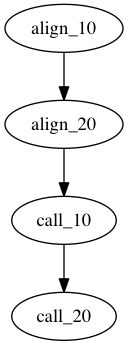

In [36]:
%preview forward.dot
%run -d forward
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

defines a nested workflow that combines workflows `align` and `call` so that the workflow will by default execute two workflows, but can also execute one of them as separate workflows `align` and `call`. This example also uses option `-d` to output the execution path of the workflow to a file, and magic `%preview` to preview the path.

Nested workflow also allows you to define multiple mini-workflows and connect them freely. For example

```python
[a_1]
[a_2]
[b]
[c]
[d_1]
sos_run('a+b')
[d_2]
sos_run('a+c')
```

defines workflows `d` that will execute steps `d_1`, `a_1`, `a_2`, `b_0`, `d_2`,  `a_1`, `a_2`, and `c_0`. 

A `parameter` statement usually gets its value from command line. However, when a workflow is executed as a subworkflow by action `sos_run`, the `parameter` statement can get its value from the `args` or `**kwargs` parameters of `sos_run`.

For example, when the `default` workflow of the following script is executed, `cutoff` takes its default value of `10`. 

In [37]:
%run
[default_1]
parameter: cutoff=10
sh:
  echo ${cutoff}

[batch]
for cutoff in range(3):
    sos_run('default', cutoff=cutoff)

A command line argument can be used to set this parameter to `8`,

In [38]:
%rerun --cutoff 8

Now, if the workflow is called as a subworkflow of step `batch`, `sos_run` set up the environment so that the statement `parameter: cutoff=10` gets a different cutoff value pass by  `sos_run`.

In [39]:
%rerun batch 

Because `sos_run` is simply a SoS action and takes a string as its parameter, it allows very flexible ways to compose (e.g. determine workflow from command line arguments) and execute (e.g. repeated execution of workflows with different options or input files) complex workflows.

### Makefile-style workflow

Using **auxiliary steps** that are only executed to provide desired output, a SoS workflow can be constructed dynamically to produce the specified target. For example, the following pipeline does not have any numbered steps and is triggered by option `-t test.vcf` (target).

%preview test.vcf

input: test.bam output: test.vcf

> test.vcf (0 B):

%preview target*.dot

> target.dot (118 B):

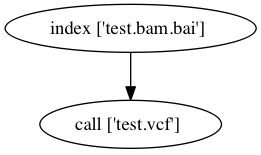

In [40]:
%sandbox
# preview multiple DAG
%preview target*.dot
!touch test.bam

%run -t test.vcf -d target

# this step provides variable `var`
[index: provides='{filename}.bam.bai']
input: "${filename}.bam"
sh:
   echo "Generating ${output}"
   touch ${output}

[call: provides='{filename}.vcf']
input:   "${filename}.bam"
depends: "${input}.bai"
sh:
   echo "Calling variants from ${input} with ${depends} to ${output}"
   touch ${output}

In this example, SoS first look for a step that can produce `test.vcf` and found the `call` step through pattern `{filename}.vcf`. It turns out that this step requires an existing input file `test.bam` but a missing dependent file `test.bam.bai`, so it continues to check the workflow to identify step `index` that generates `test.bam.bai` from `test.bam`. With all dependencies met, as illustrated by the DAG (Direct Acyclic Graph) of this workflow, two steps, `index` and `call` are executed to produce the output `test.vcf`. Please refer to a [tutorial on auxiliary steps](../tutorials/Auxiliary_Steps.ipynb) for details.

### Mixed style workflows

Auxiliary steps provide a mechanism to produce missing targets and can also be used in forward-time workflows. The resulting workflows have a numbered "stem" steps and an arbitrary number of auxiliary steps that provide required input and dependent files for these steps. For example, the following example demonstrates the use of a nested workflow with two forward-style workflows with assistance from two auxiliary steps.

align_10
align_20
call_10
call_20


%preview mixed*.dot

> mixed.dot (269 B):

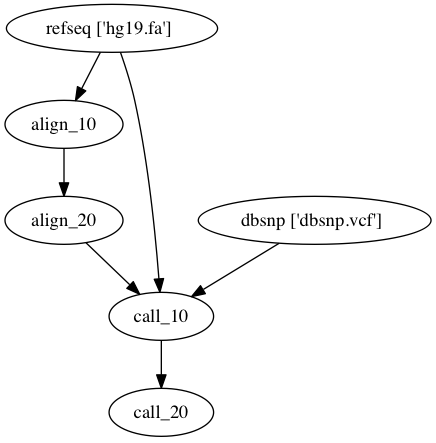

In [41]:
%sandbox

%preview mixed*.dot
%run -d mixed

[align_10]
depends: 'hg19.fa'
print(step_name)
[align_20]
print(step_name)
[call_10]
depends: 'dbsnp.vcf', 'hg19.fa'
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

[refseq: provides='hg19.fa']
sh:
    # a real step would download a fasta file for hg19
    touch hg19.fa

[dbsnp: provides='dbsnp.vcf']
sh:
    touch dbsnp.vcf
